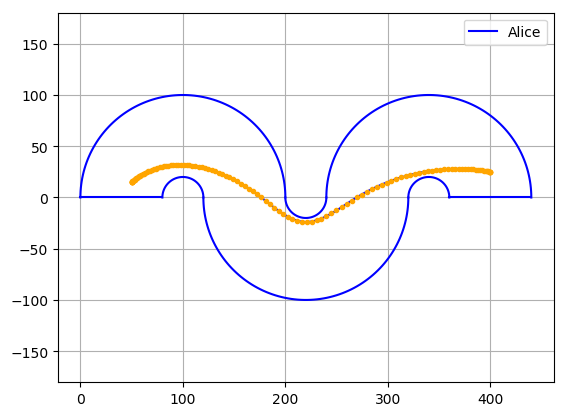

Optimal
Total energy: 7.422235876201956e7
Meeting location: (400.0, 25.0)


In [192]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 120
start = [50, 15]
finish = [400, 25]
#time_step = 36
circles = [100 0;
            100 0;
            ]
circles_U = [ 220 0;
            220 0;]
circles2 = [340 0;
            340 0;]


r = [20,100]

num_circles, dim = size(circles)
tstep = time/3

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Alice's initial position
@constraint(m, v_A[:, 1] .== [0, 0]) # Alice's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 440  )
@constraint(m, -100 .<= x_A[2, :] .<= 100  )

#setvalue(x_A[:, 13], [20, 25])
#setvalue(x_A[:, 25], [100, 40])

# Keep path away from obstacles defined by radii from circle center
for t in 1:60
        @NLconstraint(m, (x_A[1,t]-circles[1,1])^2 + (x_A[2,t]-circles[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles[2,1])^2 + (x_A[2,t]-circles[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end

for t in 80:120
        @NLconstraint(m, (x_A[1,t]-circles2[1,1])^2 + (x_A[2,t]-circles2[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles2[2,1])^2 + (x_A[2,t]-circles2[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] >= 0)
end


for t in 60:80
        @NLconstraint(m, (x_A[1,t]-circles_U[1,1])^2 + (x_A[2,t]-circles_U[1,2])^2  >= (r[1] + r[1]/5)^2) 
        @NLconstraint(m, (x_A[1,t]-circles_U[2,1])^2 + (x_A[2,t]-circles_U[2,2])^2  <= (r[2])^2)
        @constraint(m, x_A[2,t] <= 0)
end
# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Alice's position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Alice's velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

# Adds up euclidian distance between each time step
#d_tot = @NLexpression(m, sum{ (x_A[1,t+1]-x_A[1,t])^2 + (x_A[2,t+1]-x_A[2,t])^2, t=1:time-1} )  

#@NLobjective(m, Min, d_tot)
@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

# Output
x_A = getvalue(x_A)
println("Total energy: ", getobjectivevalue(m))
println("Meeting location: (", x_A[1,time],", ",x_A[2,time],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Alice")
#plot(x_A[1, time_step], x_A[2, time_step], ".", color="orange")
t = range(0,stop=pi,length=100)   

for c in 1:num_circles
    plot( circles[c,1] .+ r[c]*cos.(t), circles[c,2] .+ r[c]*sin.(t), color="blue")  # plot circle radius r with center (x1, x2)
    plot( circles2[c,1] .+ r[c]*cos.(t), circles2[c,2] .+ r[c]*sin.(t), color="blue")
    plot( circles_U[c,1] .- r[c]*cos.(t), (circles_U[c,2] .+ r[c]*sin.(t2)).*-1, color="blue")
end

botWallLX = range(0, stop=80, length = 10)
botWallLY = 0*botWallLX
plot(botWallLX, botWallLY, color="blue")

botWallRX = range(360, stop=440, length = 10)
botWallRY = 0*botWallRX
plot(botWallRX, botWallRY, color="blue")

plot(start[1], start[2], ".", color="orange")
plot(finish[1], finish[2], ".", color="orange")

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;

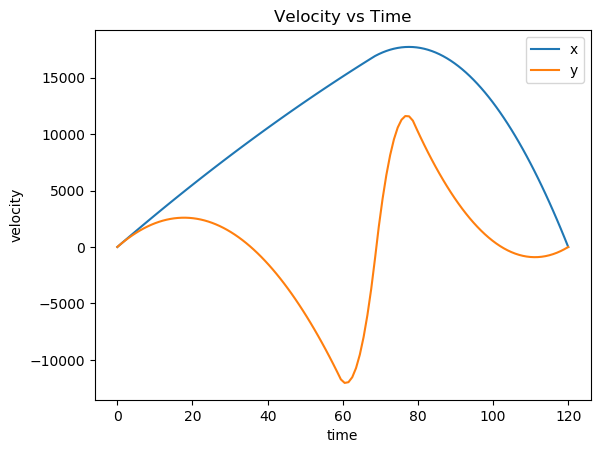

In [193]:
x = range(0, stop=time, length=time)
plot(x[:], getvalue(v_A)[1,:], label="x" )
plot(x[:], getvalue(v_A)[2,:], label="y" )
title("Velocity vs Time")
xlabel("time")
ylabel("velocity")
legend()
;

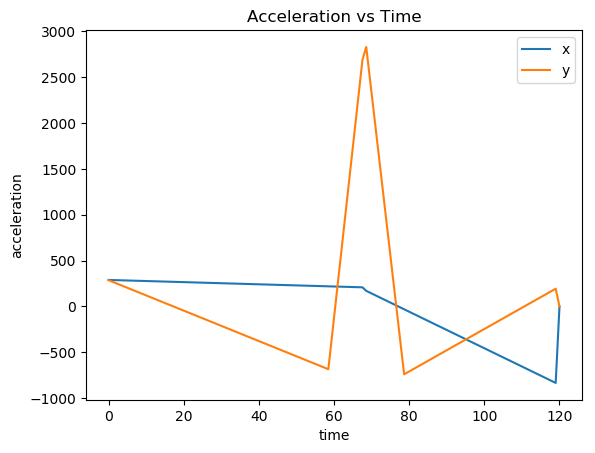

In [194]:
x = range(0, stop=time, length=time)
plot(x[:], getvalue(u_A)[1,:], label="x" )
plot(x[:], getvalue(u_A)[2,:], label="y" )
title("Acceleration vs Time")
xlabel("time")
ylabel("acceleration")
legend()
;